Plots:

1) Distribution - boxplot, densityplot, violin, histogram

2) Distribution of multiple variables - scatter, bubble-scatter, heatmap, correlogram, densityplot

3) Rankings - barplot, lolipop plot, spider, parallellines, circular barplot

4) Part of a whole - stacked barplot, donut plot, pie chart, treemap, dendrogram, venn diagram, sunburst

Primary purpose of this notebook is not to learn how to use matplotlib/seaborn efficiently, but rather how
to achieve any effect you want with these tools. 

Main source of possibilities for me was this site:
https://python-graph-gallery.com/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.gridspec as gridspec
import matplotlib.patches as patch
import seaborn as sns
import numpy as np
import math
import matplotlib
import re
from matplotlib.patches import Patch
import bokeh
from matplotlib_venn import venn3
import squarify

In [2]:
#Codes for my own color interpolation
#string to int with 2 slots - hexadecimal to decimal
def hextodec(a):
    x=0; clr=0; av=1
    L=len(a)
    
    for i in range(L):
        clr=ord(a[L-i-1])
        if (clr>=65):
            clr-=55
        else:
            clr-=48
        x=x+av*clr
        av*=16
    return x

#integer to string with 2 slots - decimal to hexadecimal
def dectohex(a):
    l=[0]*2
    
    for i in range(2):
        x=a%16
        if (x<10):
            l[1-i]=chr(x+48)
        else:
            l[1-i]=chr(x+55)
        a=a//16
    return ''.join(l)

#interpolation of colors - I take n colors between color a(hex - ex. '#EE8800'), and color b
def colorize(a, b, n):
    l=[0]*n
    d=[0]*3
    a1=[0]*3
    
    for i in range(0,3,1):
        f1=a[1+i*2:3+i*2]
        f2=b[1+i*2:3+i*2]
        a1[i]=f1=hextodec(f1)
        f2=hextodec(f2)
        d[i]=(f2-f1)//n
    
    for i in range(0, n, 1):
        l[i]='#'
        for j in range(0, 3, 1):
            l[i]+=dectohex(a1[j])
            a1[j]+=d[j]
    return l

#Create 2 random colors with difference in 1 dimension equal diff - useful for interpolation
def gen_rand_colors(diff):
    if (diff>128):
        diff=128
    
    l=[0]*3
    l2=[0]*3
    
    for i in range(0,3,1):
        l[i]=l2[i]=np.random.randint(0,256)
    x=np.random.randint(0,3)
    if (l[x]<=255-diff):
        l2[x]=l[x]+diff
    else:
        l2[x]=l[x]-diff
    
    s1='#'; s2='#'
    for i in range(0,3,1):
        s1+=dectohex(l[i])
        s2+=dectohex(l2[i])
    return (s1, s2)


In [3]:
#Purifying the dataset
df=pd.read_csv('/kaggle/input/H3Units.csv')

#Creating new attribute - type of an unit
df['Type']='Warrior'
#Devil and archdevil have property 'Teleporting' equivalent to flying
k=df['Special_abilities'].str.contains('Flying|Teleporting')
l=df['Special_abilities'].str.contains('Ranged')
df.loc[k,'Type']='Flying'
df.loc[l,'Type']='Ranged'

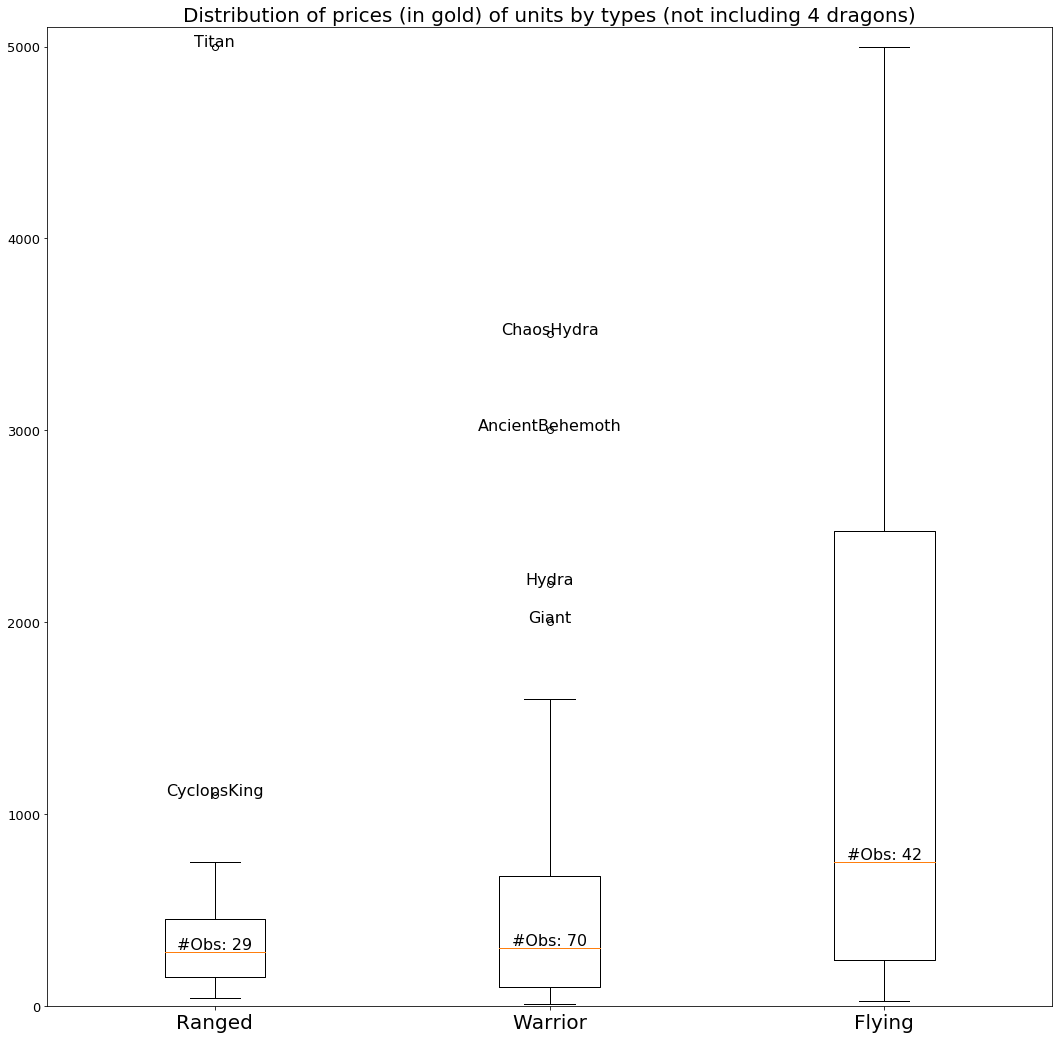

In [4]:
#Distriution #1 - boxplot - Distribution of prices (in gold) of units in certain castles
#Boxplot: central line - mediana, box - interval between I and III quartile, curl - min(max_obs, Q3+IQR*2) and max(min_obs, Q1-IQR*2) where IQR - interquartile range
f='Type'
df2=df.loc[:,['Unit_name', f, 'Gold']]
df3=df2.groupby([f], as_index=False).median().sort_values(by='Gold')
k=df3[f]

l1=[0]*len(k)
l2=[0]*len(k)
for i in range(len(k)):
    l1[i]=df2[df2[f]==k[k.index[i]]].loc[:,'Gold']
    l2[i]=df2[df2[f]==k[k.index[i]]].loc[:,'Unit_name']

fig, ax=plt.subplots(1,1)
fig.set_size_inches(18,18)
ax.boxplot(l1, labels=k, whis=2)

ax.set_ylim(0, 5100)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=13)
ax.set_title('Distribution of prices (in gold) of units by types (not including 4 dragons)', fontsize=20)

#Showing text description - outliers and number of observations
for i in range(len(l1)):
    ax.text(x=1+i, y=l1[i].median(), s='#Obs: '+str(len(l1[i])), horizontalalignment='center', verticalalignment='bottom', fontsize=16)
    #Quartiles and Interquartile range
    Qr1=np.percentile(l1[i], 25)
    Qr3=np.percentile(l1[i], 75)
    IQR=Qr3-Qr1
    #Detecting outliers and showing description
    for j in range(len(l1[i])):
        if (l1[i][l1[i].index[j]]>Qr3+IQR*1.75 and l1[i][l1[i].index[j]]<ax.get_ylim()[1]):
            ax.text(x=1+i, y=l1[i][l1[i].index[j]], s=l2[i][l2[i].index[j]], horizontalalignment='center', fontsize=16)

plt.show()

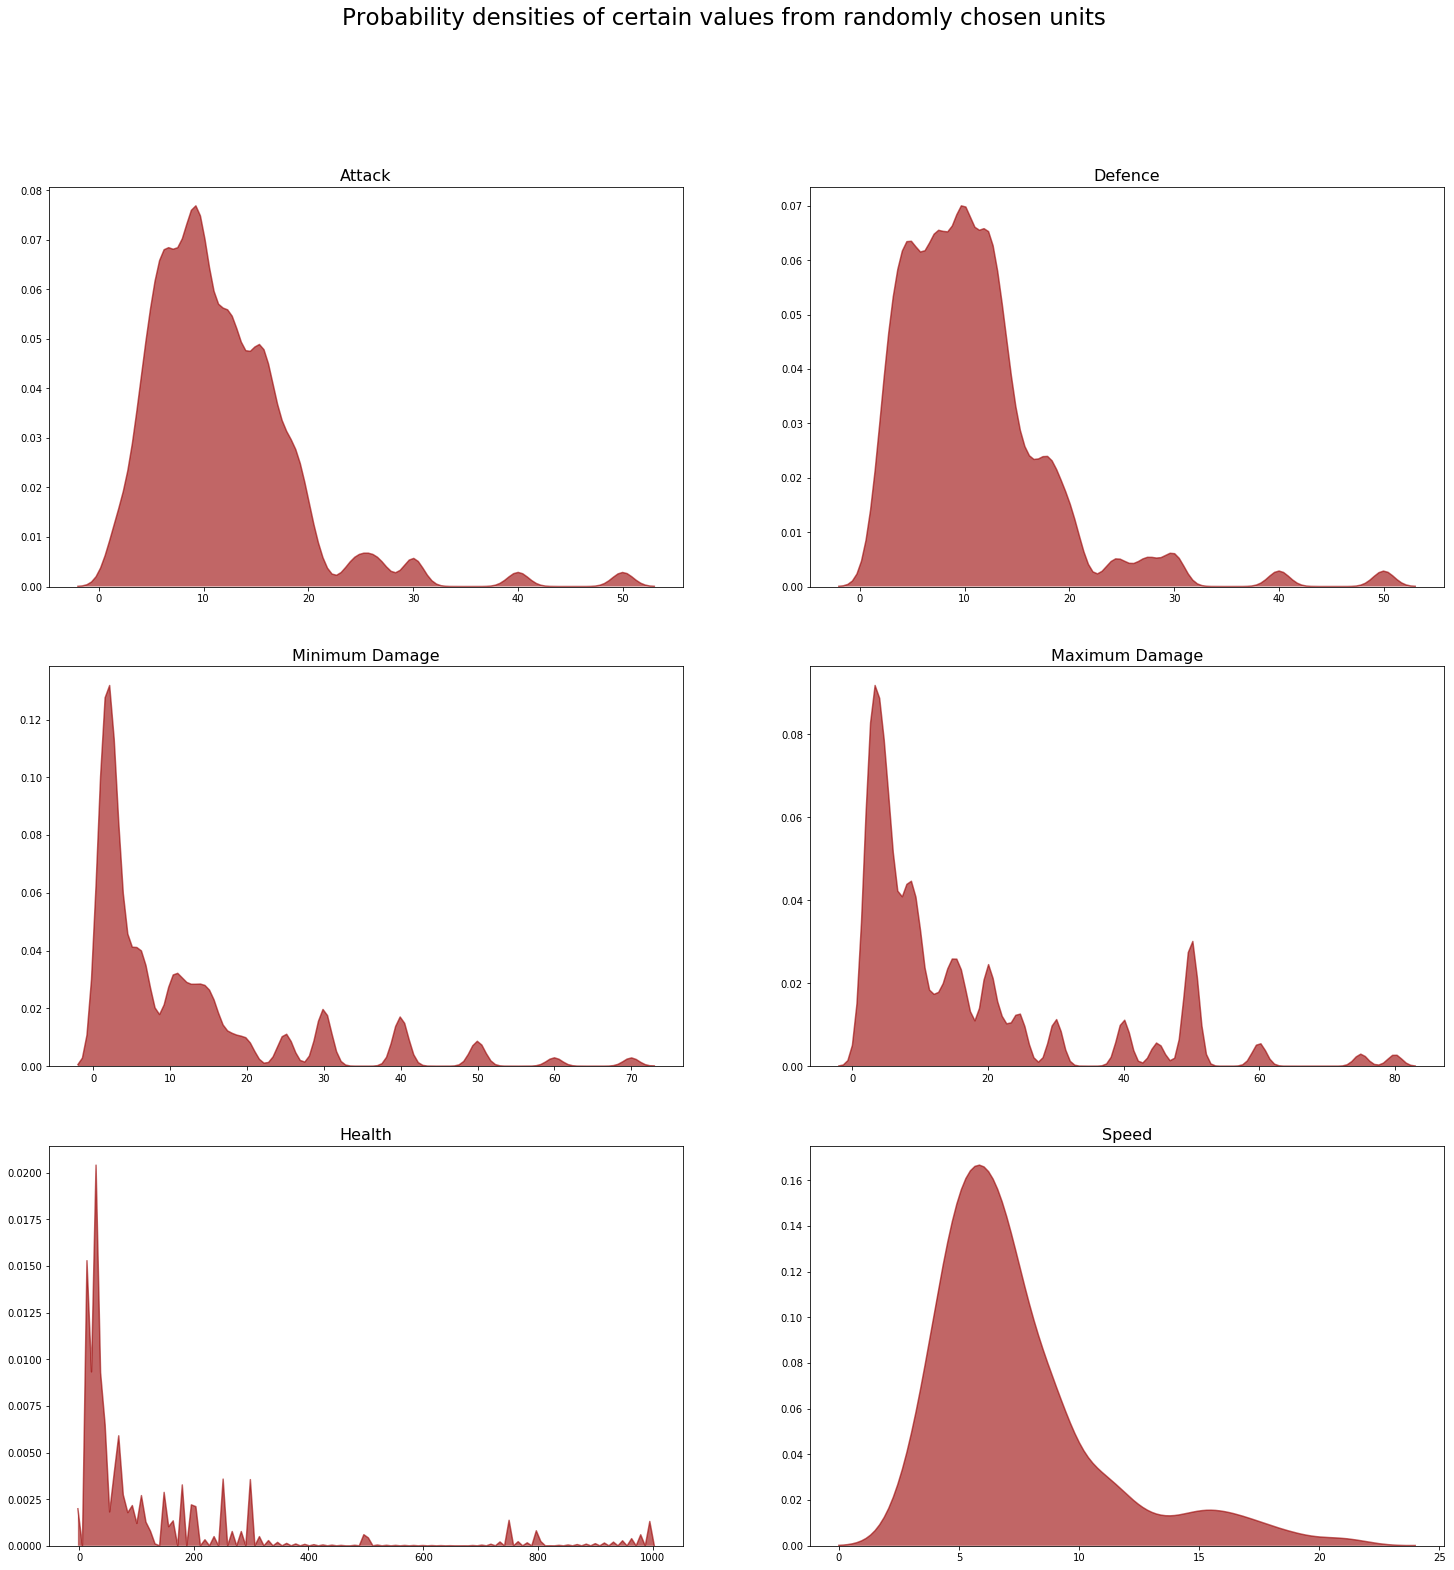

In [5]:
#Distribution #2 - density plot in 1 dimension - better version of histogram
#De facto plummed histogram estimated from kernel density estimation
#Size of 'bins' can be modelled by 'bw' parameters
fig, ax=plt.subplots(3, 2)
fig.set_size_inches(25,25)

for j in range(0, 6, 1):
    fax=ax[j//2][j%2]
    sns.kdeplot(data=df.loc[:,df.columns[3+j]], ax=fax, shade=True, bw=1, alpha=0.6, color='#990000')
    fax.set_title(df.columns[3+j], fontsize=16)
    fax.get_legend().remove()
fig.suptitle('Probability densities of certain values from randomly chosen units', fontsize=23)
plt.show()

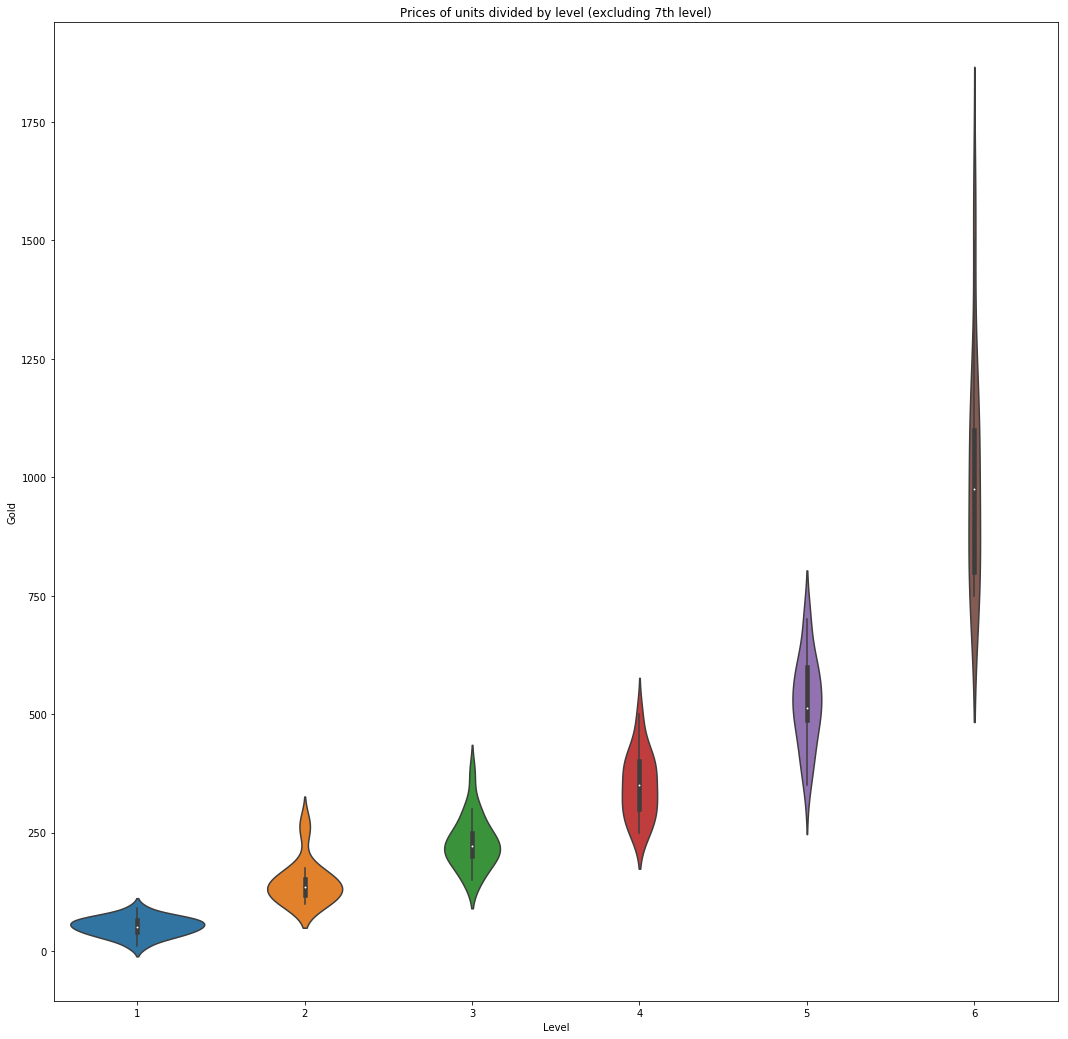

In [6]:
#Distribution #3 - Violin plot - enchances normal boxplot with densities
df2=df.copy()
df2['Level']=df2['Level'].apply(lambda x: re.sub('\+.*', '', x))

fig, ax=plt.subplots(1,1,figsize=(18,18))
sns.violinplot(x='Level', y='Gold', data=df2[df2['Level']!='7'], inner='box')
ax.set_title('Prices of units divided by level (excluding 7th level)')

plt.show()

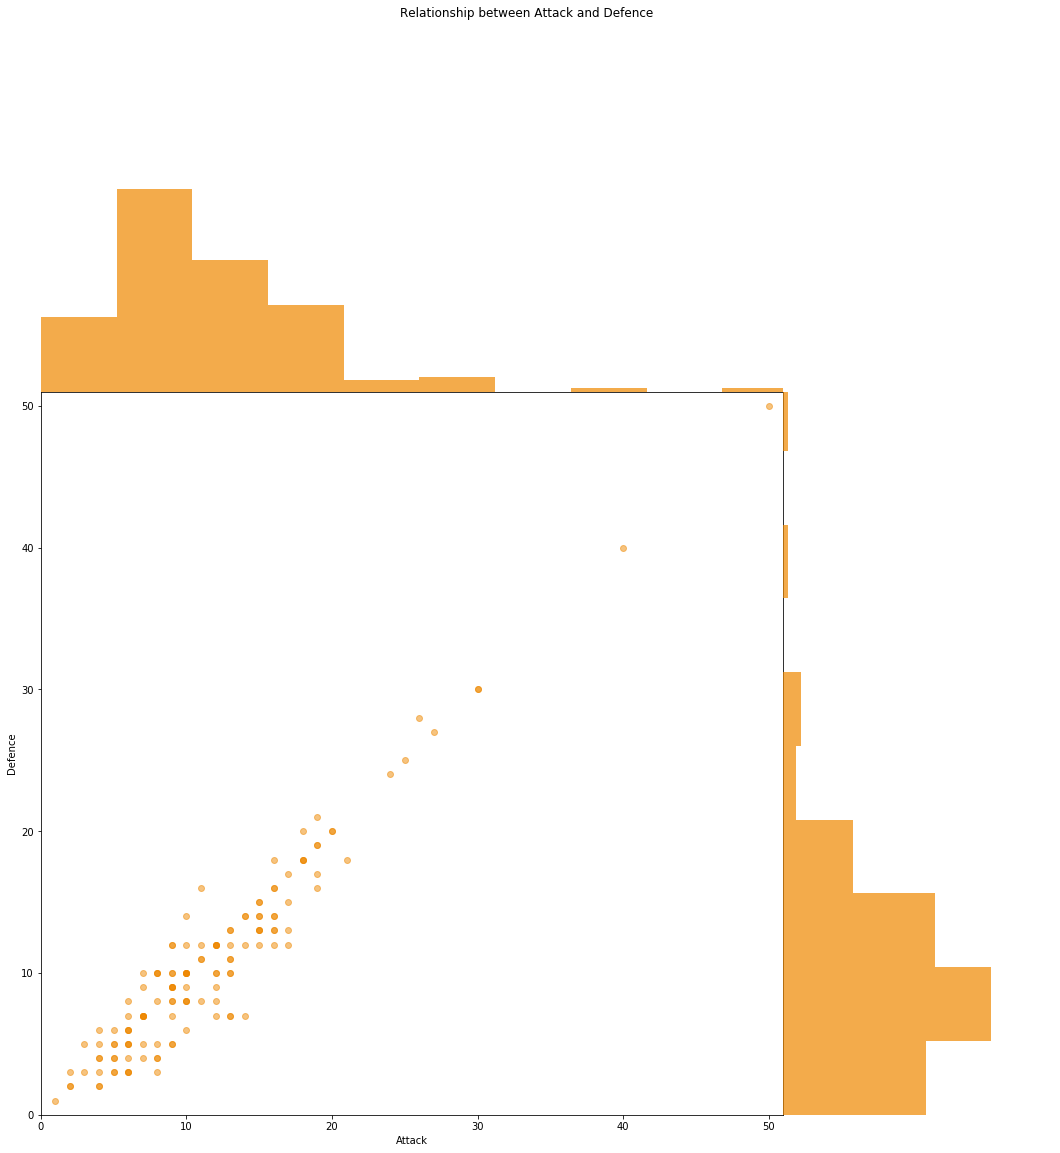

In [7]:
#Distribution #4 + Distribution of variables #1 - scatterplot with histogram (jointplot)
fig, ax=plt.subplots(1,1,figsize=(18,18))
gs=gridspec.GridSpec(4,4)
ax.axis('off')

ax=[0]*4
ax[0] = fig.add_subplot(gs[0, 0:3])
ax[1] = fig.add_subplot(gs[0, 3])
ax[2] = fig.add_subplot(gs[1:4, 0:3])
ax[3] = fig.add_subplot(gs[1:4, 3])

#Parameters of comparision
ParA='Attack'
ParB='Defence'

#Creating upper histogram
ax[0].hist(ParA, bins=10, range=(0,51), data=df, alpha=0.7, color='#EE8800')
ax[0].set_xlim(0,50)
ax[0].set_xticks([])
ax[0].axis('off')
#Placing upper histogram right above the scatterplot
K=ax[0].get_position()
wid=K.y1-K.y0
hei=K.x1-K.x0
ax[0].set_position([K.x0, ax[2].get_position().y1, hei, wid])

#Hiding plot in corner
ax[1].axis('off')

#Creating right histogram
ax[3].hist(ParB, range=(0,51), data=df, orientation='horizontal', alpha=0.7, color='#EE8800')
ax[3].set_ylim(0,50)
ax[3].set_yticks([])
#Placing upper histogram to the right of scatterplot
K=ax[3].get_position()
wid=K.y1-K.y0
hei=K.x1-K.x0
ax[3].set_position([ax[2].get_position().x1, K.y0, hei, wid])
ax[3].axis('off')

#Creating scatterplot
ax[2].scatter(ParA, ParB, data=df, color='#EE8800', alpha=0.5)
ax[2].set_xlabel(ParA)
ax[2].set_ylabel(ParB)
ax[2].set_xlim(0,max(df[ParA])+1)
ax[2].set_ylim(0,max(df[ParB])+1)


fig.suptitle('Relationship between '+ParA+' and '+ParB)

plt.show()

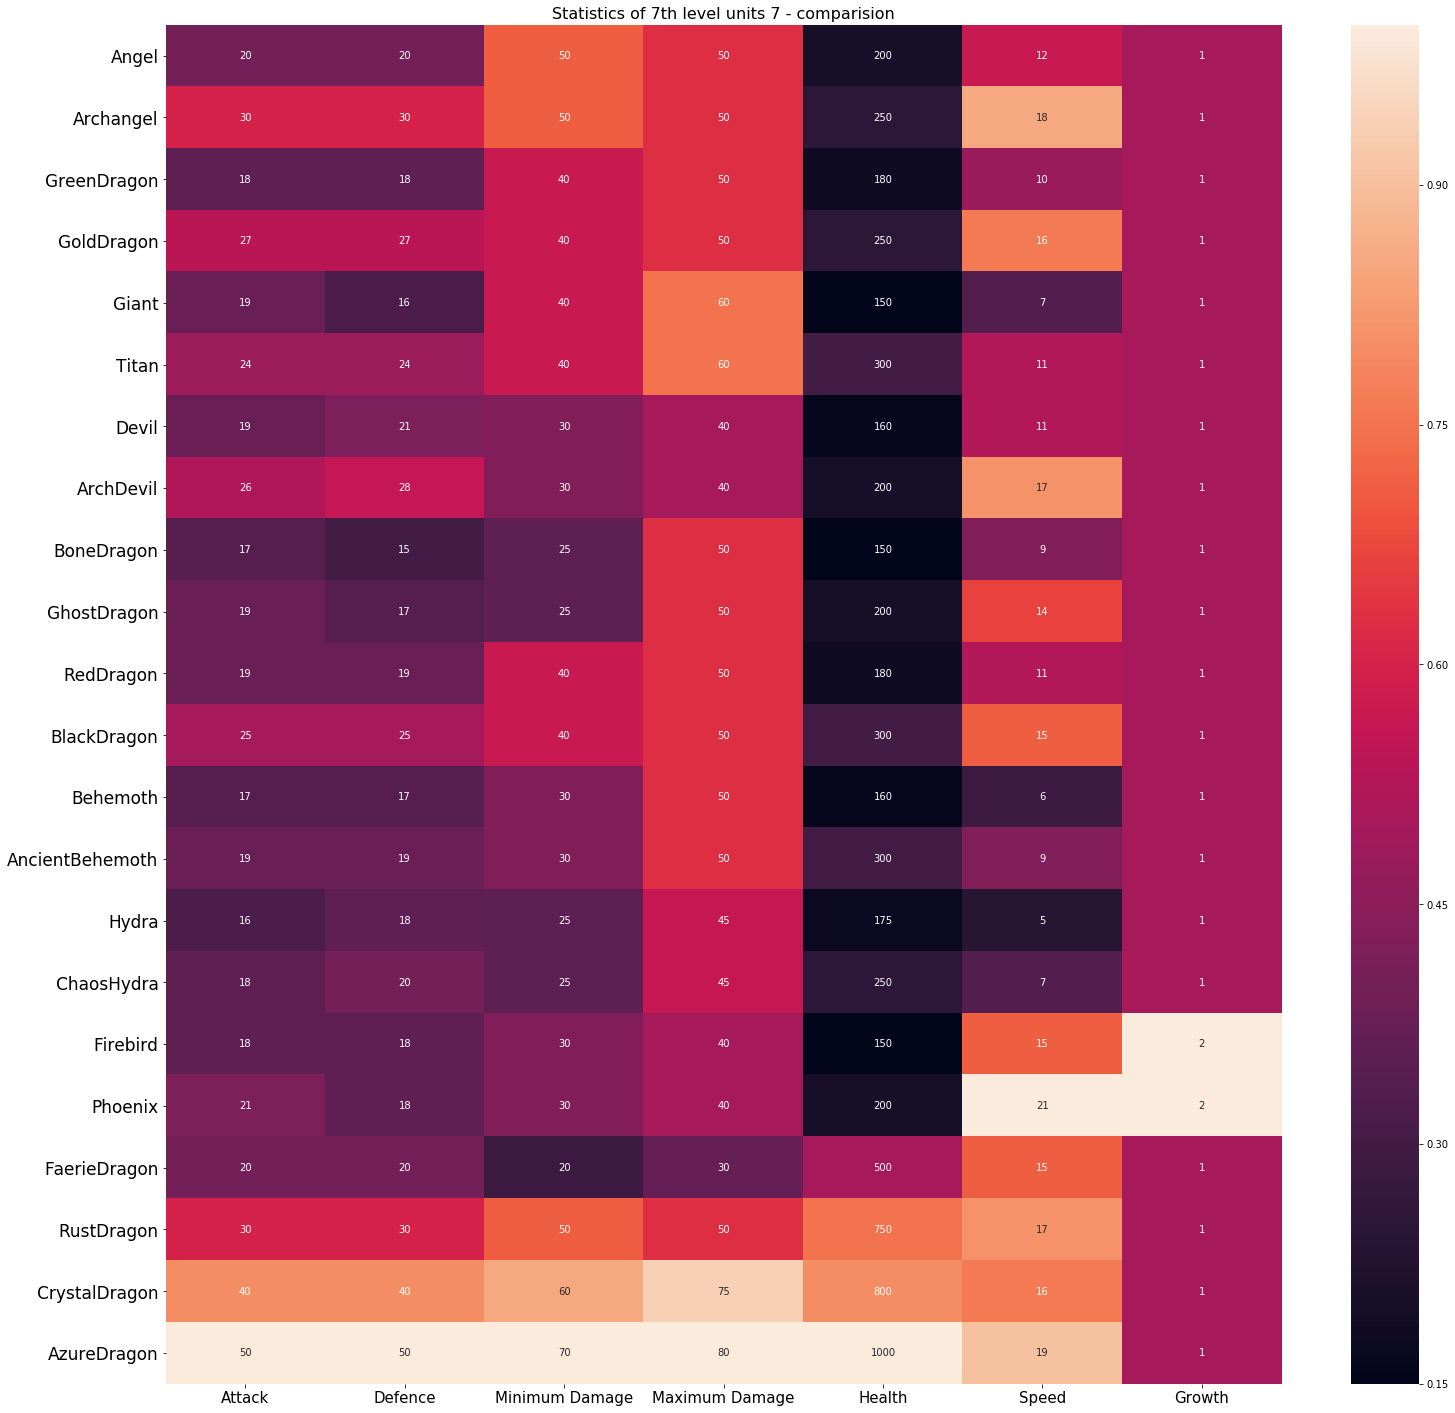

In [8]:
#Correlation #3 - heatmap with normalization (proportions from interval 0-1)
#legend shows proportions (the ligter the color, the bigger the value)
def besserheatmap(df, ax, labels=2.312, ant=False):
    #Proporiton - normalization of values in column - without it everything would be black, for max(health)=1000 has much bigger value than other stats
    for i in range(0, df.shape[1], 1):
        mn=df.iloc[:,i].max()
        df.iloc[:,i]=df.iloc[:,i]/mn
    
    #Creating map and scales on axis, fmt='d' - format to normal digit
    sns.heatmap(data=df, ax=ax, annot=ant, fmt='d')
    ax.yaxis.set_tick_params(labelrotation=0, labelsize=17)
    ax.xaxis.set_tick_params(labelrotation=0, labelsize=15)
    ax.set_ylim(df.shape[0], 0)
    
    #details on y axis
    x=[0.5]*df.shape[0]
    for i in range(1, len(x), 1):
        x[i]=x[i-1]+1
    ax.set_yticks(x)
    ax.set_ylim(df.shape[0], 0)
    
    #Was argument 'labels' passed? completely ridiculous solution, but works
    if (type(labels)!=type(2.13)):
        ax.set_yticklabels(labels)
    
    

fig, ax=plt.subplots(1,1)
fig.set_size_inches(25,25)

df2=df[(df['Level']=='7') | (df['Level']=='7+')]
GG=df2.loc[:,df.dtypes=='int64']
lGG=df2.loc[:,'Unit_name']
GG=GG.iloc[:,0:7]

besserheatmap(df=GG, ax=ax, labels=lGG, ant=GG.copy())
ax.set_title('Statistics of 7th level units 7 - comparision', fontsize=16)

plt.show()

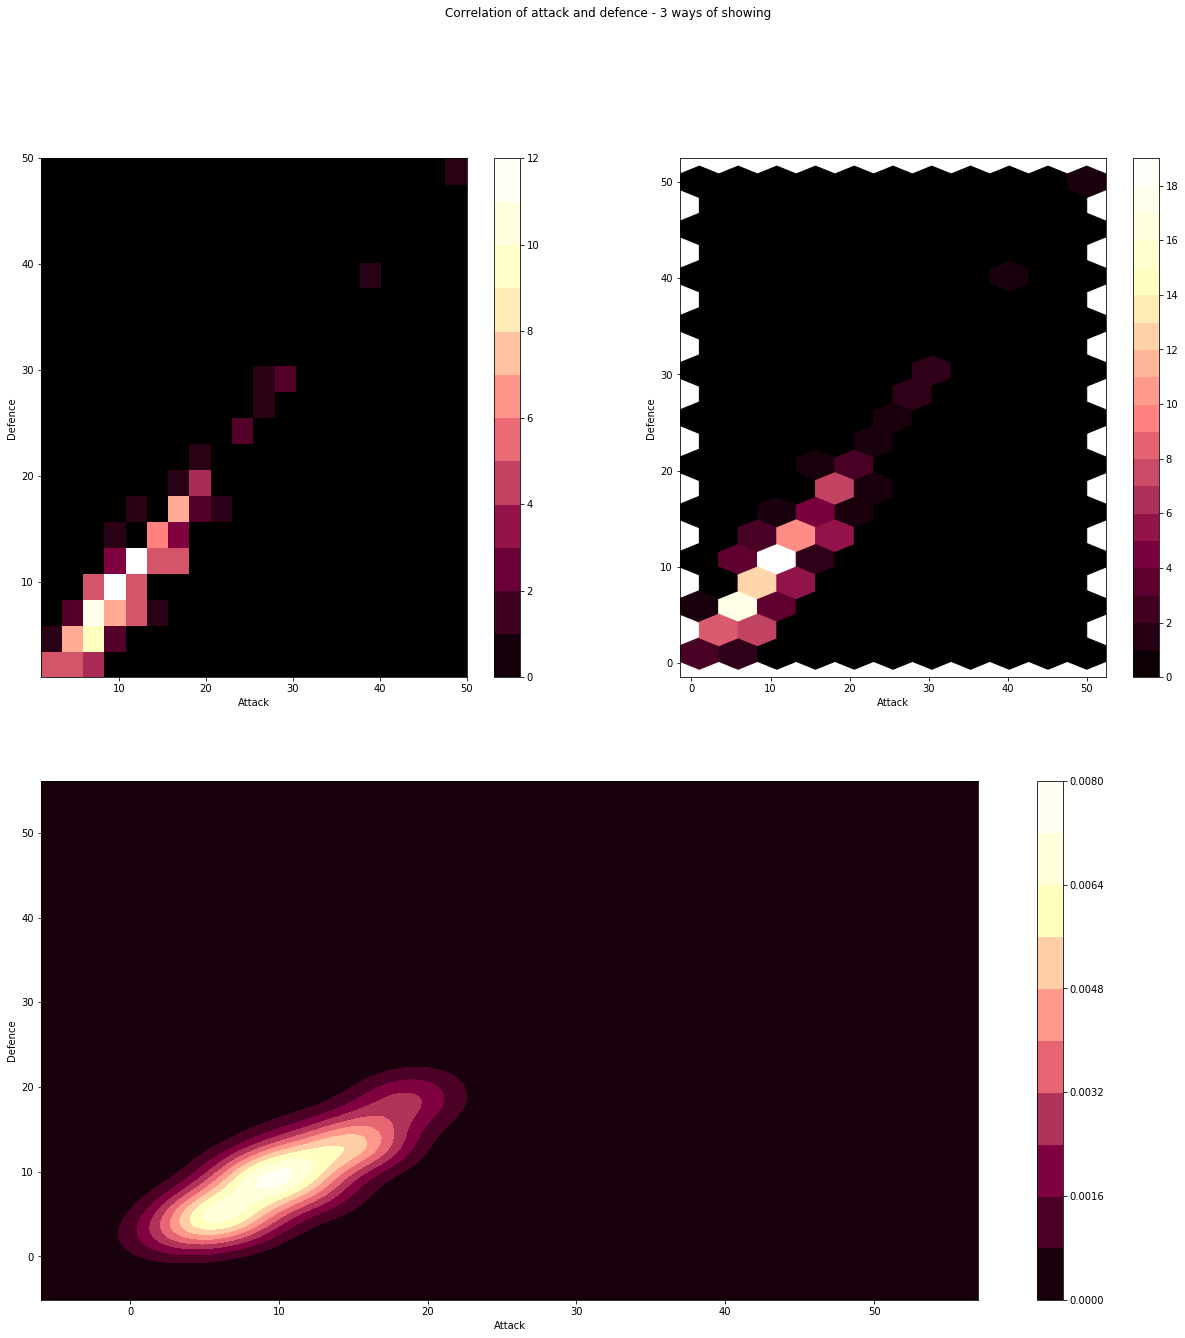

In [9]:
#Correlation #4 - Denstity plots, 3 methods - 2-dimensional histogram/hex bins/kde dentsity(contour(seaborn))
#Appropriate for analysis of large datasets - not the case with this dataset, but on larger one points would create a cloud with unclear point concentration
#Plot shows relation between Attack and defence

#dictionary from documentation of LinearSegmentedColormap - Normal randomization would give me world painted by shades of grey
#Creating own Cmap - dict (x,y1,y2) interpolates interval x[i-1]:x[i] -> y[i-1][2]:y[i][1]
cdict = {'red':   [(0.0,  0.0, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'blue':  [(0.0,  0.0, 0.0),
                   (1.0,  1.0, 1.0)]}
z=matplotlib.colors.LinearSegmentedColormap(name='Kappa', segmentdata=cdict)


X=df['Attack']
Y=df['Defence']
#Gridspec - Allows me to divide plot as I like
gs=gridspec.GridSpec(2,2)
fig, ax=plt.subplots(2,2, figsize=(21,21))

h1=ax[0][0].hist2d(X, Y, bins=(20, 20), cmap=z)

#I search for max and min form all values on hist, then I create colorbar
mn=1000; mx=0
for i in range(0, len(h1[0]), 1):
    for j in range(0, len(h1[0][i]), 1):
        mn=min(h1[0][i][j], mn)
        mx=max(h1[0][i][j], mx)
        
Z = [[0,0],[0,0]]
levels = range(int(mn),int(mx)+1,1)
Map1 = plt.contourf(Z, levels, cmap=z)
#theoretically I should have hidden the plot above, but it is already hidden (plt.clear())
fig.colorbar(Map1, ax=ax[0][0])


#Analogous for hexbin
g=ax[0][1].hexbin(X, Y, gridsize=(10,10), cmap=z)
g=g.get_array()
mn=1000; mx=0
for i in range(0, len(h1[0]), 1):
    mn=min(g[i], mn)
    mx=max(g[i], mx)
levels = range(int(mn),int(mx)+1,1)
Map2 = plt.contourf(Z, levels, cmap=z)
fig.colorbar(Map2, ax=ax[0][1])

#Merging 2 parts of figure - now as ax[1][0], then plot - kdeplot w 2 wymiarach
ax[1][0]=plt.subplot(gs[1, :])
sns.kdeplot(data=X, data2=Y, ax=ax[1][0], cmap=z, shade=True, cbar=True)

#Titles of axes
for i in range(0, 3, 1):
    ax[i//2][i%2].set_xlabel('Attack')
    ax[i//2][i%2].set_ylabel('Defence')

fig.suptitle('Correlation of attack and defence - 3 ways of showing')


plt.show()

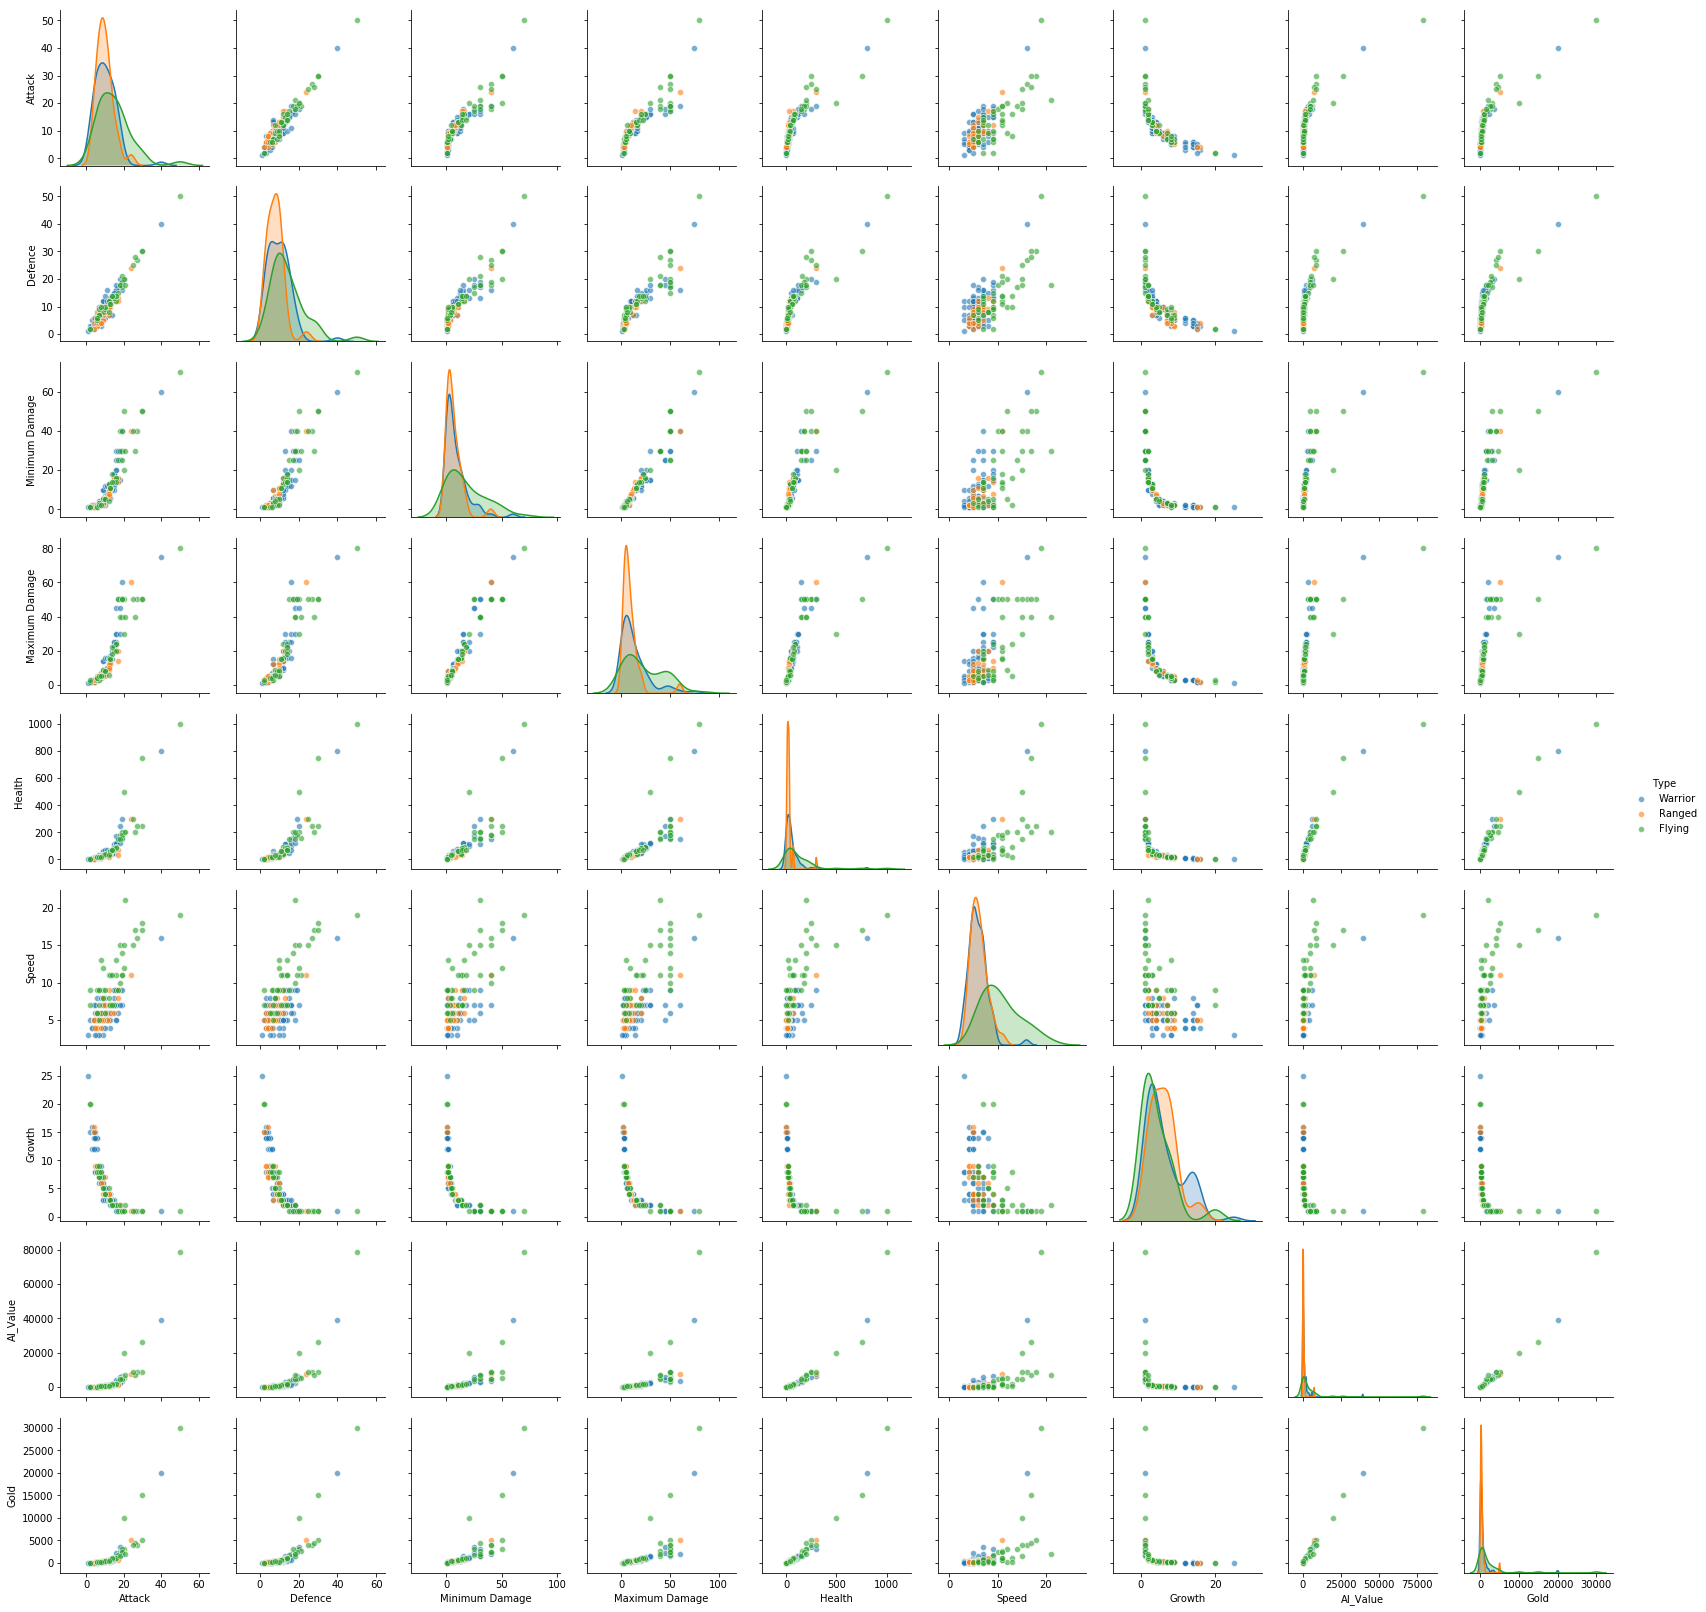

In [10]:
#Correlation #5 - correlogram - enables me to analyse whole dataset in one plot - quite useful, and there rarely need for customization
sns.pairplot(df, hue='Type', diag_kind='kde', plot_kws={'alpha':0.6})
plt.show()

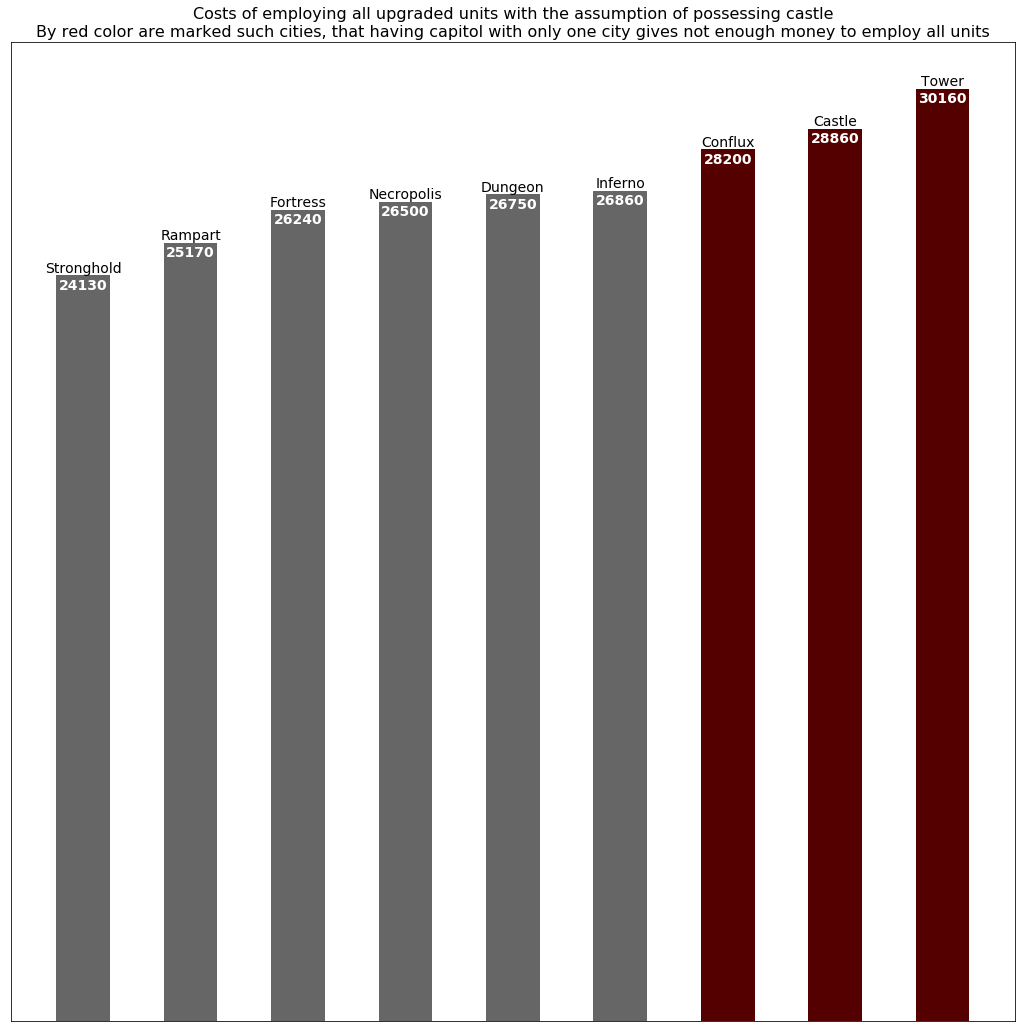

In [11]:
#ranking #1 - Barplot - summed costs of employing all units with assumption of possessing castle
df2=df.copy()
df2['All']=df2['Growth']*df2['Gold']*2
k=df2['Level'].str.contains('\+')
df2=df2[k]
df2=df2.groupby(['Castle'], as_index=False).sum().sort_values(by='All')

fig, ax=plt.subplots(1,1)
fig.set_size_inches(18,18)

cncs=df2.columns.get_loc('Castle')
cnal=df2.columns.get_loc('All')
for i in range(0, df2.shape[0], 1):
    Z=df2.iat[i, cnal]
    #Drawing bar in certain point; color is dependat upon whether value in last column is greater than 7*4000
    if (Z<28000):
        ax.bar(x=i, height=Z, color='#666666', width=0.5)
    else:
        ax.bar(x=i, height=Z, color='#550000', width=0.5)
    ax.text(x=i, y=Z-100, s=str(Z), horizontalalignment='center', verticalalignment='top', fontsize=14, color='white', weight='bold')
    ax.text(x=i, y=Z, s=df2.iat[i, cncs], horizontalalignment='center', verticalalignment='bottom', fontsize=14)

#ax.axis('off') # disabling axes - 2 methods - I haven't turned down a frame, so that there is point of reference
ax.get_yaxis().set_visible(False)
ax.set_xticks([])
ax.set_title('Costs of employing all upgraded units with the assumption of possessing castle\nBy red color are marked such cities, that having capitol with only one city gives not enough money to employ all units', fontsize=16)

plt.show()

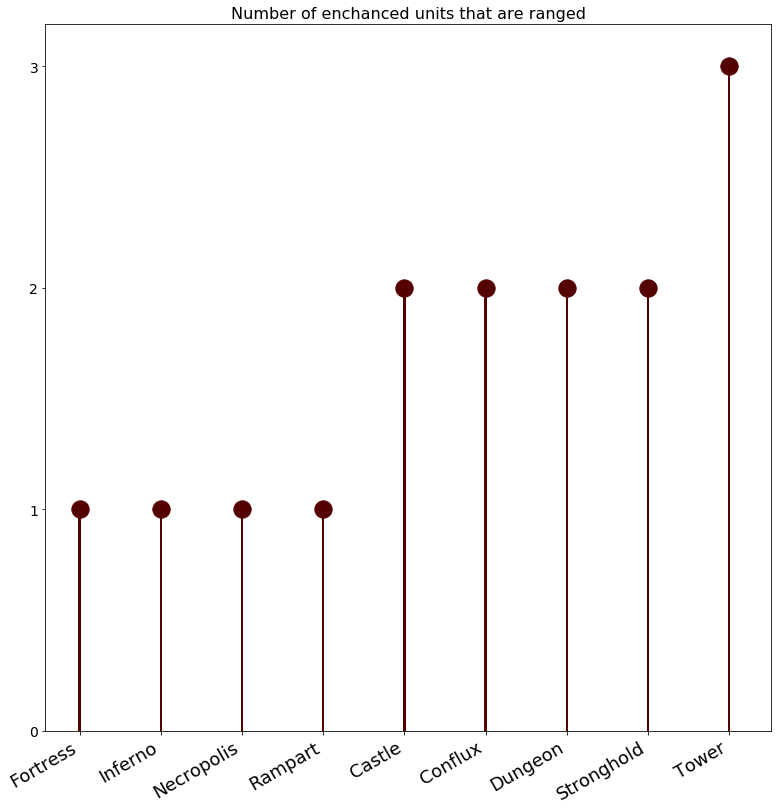

In [12]:
#ranking #2 - lolipop plot - narrow barchart with ending marked by a dot


df2=df.copy()
k=df2['Special_abilities'].str.contains('Ranged\(')
l=df2['Level'].str.contains('\+')

df2=df2[k&l]
df2['All']=1
df2=df2.groupby(['Castle'], as_index=False).sum().sort_values(by='All')


fig, ax=plt.subplots(1,1)
fig.set_size_inches(13,13)

f=df2.columns.get_loc('All')
for i in range(df2.shape[0]):
    #I create lolipop as merged bar and one scattered point - making such things in loop easens customization
    Z=df2.iat[i,f]
    ax.bar(x=i, height=Z, width=0.03, color='#550000')
    ax.scatter(x=i, y=Z, color='#550000', s=300.1)

ax.set_xticks(range(0,9,1))
ax.set_yticks(range(0,4,1))
ax.set_xticklabels(df2['Castle'], ha='right')
ax.xaxis.set_tick_params(labelsize=18, labelrotation=30)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_title('Number of enchanced units that are ranged', fontsize=16)
#plt.grid(axis='y')

plt.show()

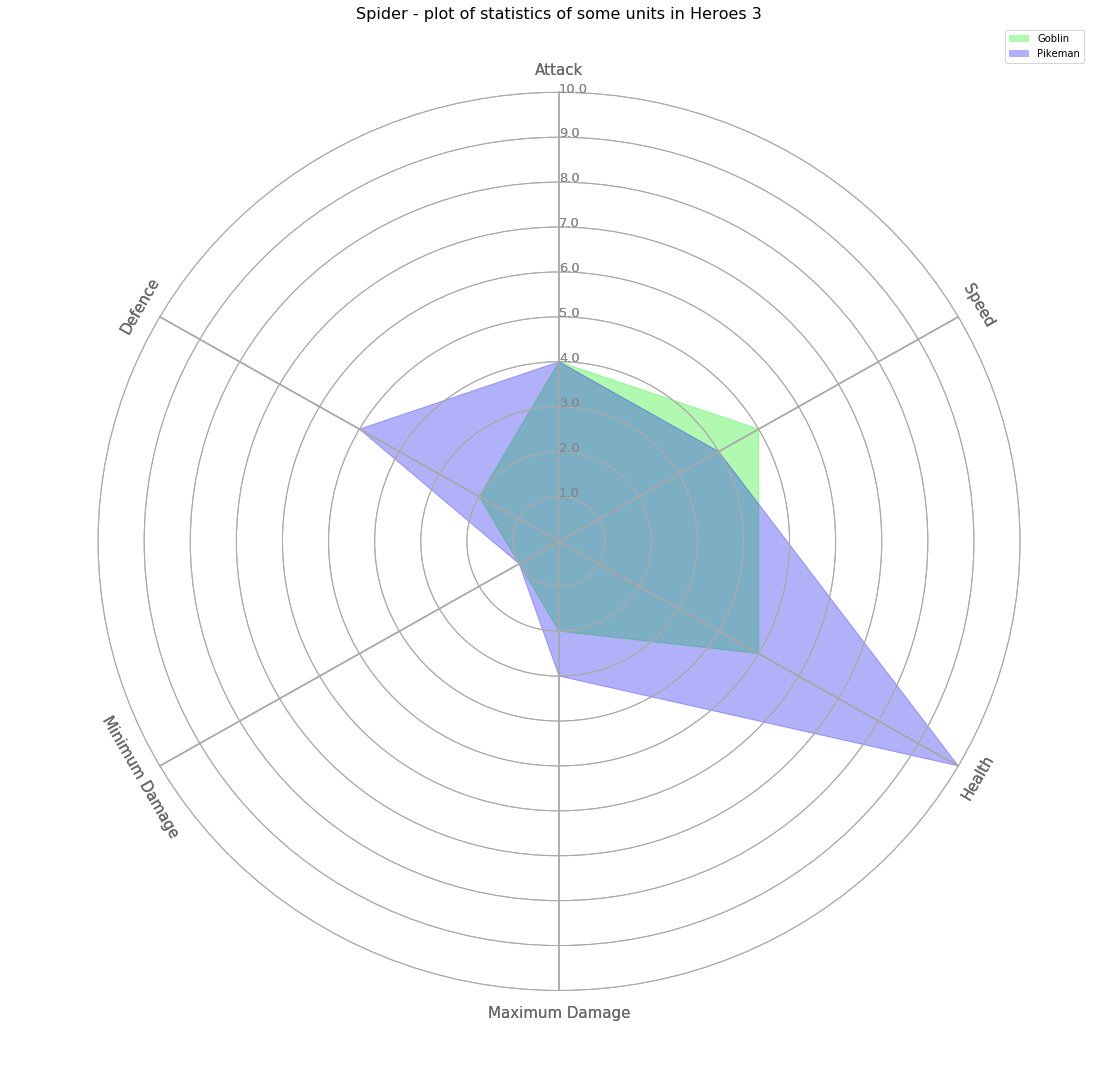

In [13]:
#ranking #3 - Spider

#allez-radius of a circle, n-number of radar's beams, m-number of circles, maxi-biggest nuber on a radar, subd-sequence with labels, ax-plot, incol-color of figure, legg-legend, lab-label
def spiderland(allez, n, m, maxi, subd, ax, incol='#EE0000', legg=[], lab='Nan'):
    #Adding new object to a legend
    legg.append(Patch(facecolor=incol, alpha=0.3, label=lab))
    
    deg=2*math.pi/n
    x=[0]*n
    y=[allez]*n

    #endpoints of radar lines
    for i in range(1, n, 1):
        x[i]=x[i-1]*math.cos(deg)-y[i-1]*math.sin(deg)
        y[i]=x[i-1]*math.sin(deg)+y[i-1]*math.cos(deg)

    #Radar
    for i in range(n):
        ax.plot([0, x[i]], [0, y[i]], color='#AAAAAA')

    #filling triangles
    i=1
    while (i<n):
        ax.fill([0, x[i-1]*int(subd[i-1])/maxi, x[i]*int(subd[i])/maxi], [0, y[i-1]*int(subd[i-1])/maxi, y[i]*int(subd[i])/maxi], alpha=0.3, color=incol)
        i+=1
    ax.fill([0, x[i-1]*int(subd[i-1])/maxi, x[0]*int(subd[0])/maxi], [0, y[i-1]*int(subd[i-1])/maxi, y[0]*int(subd[0])/maxi], alpha=0.3, color=incol)

    #Text of labels at the end of radar lines
    for i in range(n):
        roth=i*deg*(180/math.pi)
        if (roth>90 and roth<270):
            roth=180+roth
        ax.text(x=x[i]*1.05, y=y[i]*1.05, s=subd.index[i], fontsize=15, color='#666666', rotation=roth, horizontalalignment='center', verticalalignment='center')


    #Circles
    crc=[0]*m
    for i in range(m):
        crc[i]=plt.Circle((0,0), allez*(i+1)/m, color='#AAAAAA', fill=None)
        ax.add_artist(crc[i])
        ax.text(x=0, y=allez*(i+1)/m, s=str(maxi*(i+1)/m), fontsize=13, color='#888888')

    ax.set_xlim(-2.3, 2.3)
    ax.set_ylim(-2.3, 2.3)

fig, ax=plt.subplots(1,1)
fig.set_size_inches(19, 19)

leggy=[]
spiderland(2, 6, 10, 10, df[df['Unit_name']=='Goblin'].iloc[0,3:9], ax, incol='#00EE00', legg=leggy, lab='Goblin')
spiderland(2, 6, 10, 10, df[df['Unit_name']=='Pikeman'].iloc[0,3:9], ax, incol='#0000EE', legg=leggy, lab='Pikeman')
ax.legend(handles=leggy)
ax.set_title('Spider - plot of statistics of some units in Heroes 3', fontsize=16)
ax.axis('off')

plt.show()

#print(df[df['Unit_name']=='Gnoll'].iloc[0,:][2:7])

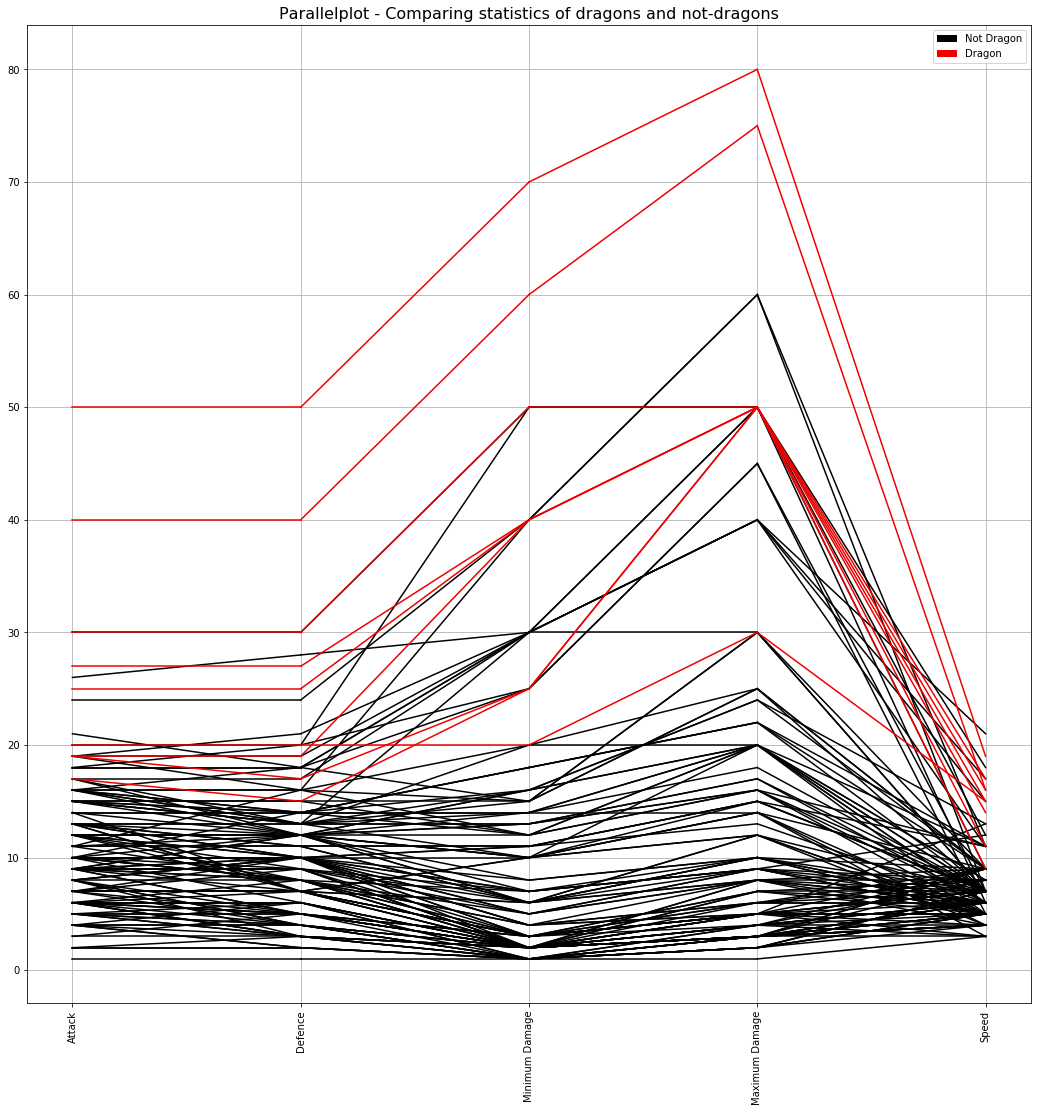

In [14]:
#ranking #4 - parallelplots - better than spider, for instead of polar coordinates there are cartesian ones
#Able to show data in any number of dimension (alike spider)
def drawparallels(ax, subd, legg=[], lab='', incol='#EE0000'):
    for j in range(1, subd.shape[0], 1):
        for i in range(1, subd.shape[1], 1):
            ax.plot([i-1, i], [subd.iat[j,i-1], subd.iat[j,i]], color=incol)
    
    legg.append(Patch(facecolor=incol, label=lab)) 
    ax.set_xticks(range(0, subd.shape[1], 1))
    ax.set_xticklabels(subd.columns)
    ax.xaxis.set_tick_params(labelrotation=90)


fig, ax=plt.subplots(1,1)
fig.set_size_inches(18,18)
colors=['#EE0000', '#888800', '#990044', '#EE0088', '#0000EE', '#00EE88', '#000000']
lg=[]

#Parallelplot with levels in comment
#for i in range(1, 8, 1):
#    mdf=df[(df['Level']==str(i)) | (df['Level']==str(i)+'+')].iloc[:,[3,4,5,6,8]]
#    drawparallels(ax, mdf, legg=lg, lab=str(i), incol=colors[i-1])

#print(df[(df['Level']==str(i)) | (df['Level']==str(i)+'+')])


k=df['Unit_name'].str.contains('Dragon$')
k[k.isna()]=False
k=k.astype('bool')

mdf=df[np.invert(k)].iloc[:,[3,4,5,6,8]]
drawparallels(ax, mdf, legg=lg, lab='Not Dragon', incol=colors[6])
mdf=df[k].iloc[:,[3,4,5,6,8]]
drawparallels(ax, mdf, legg=lg, lab='Dragon', incol=colors[0])

ax.legend(handles=lg)
ax.set_title('Parallelplot - Comparing statistics of dragons and not-dragons', fontsize=16)
ax.grid()
plt.show()

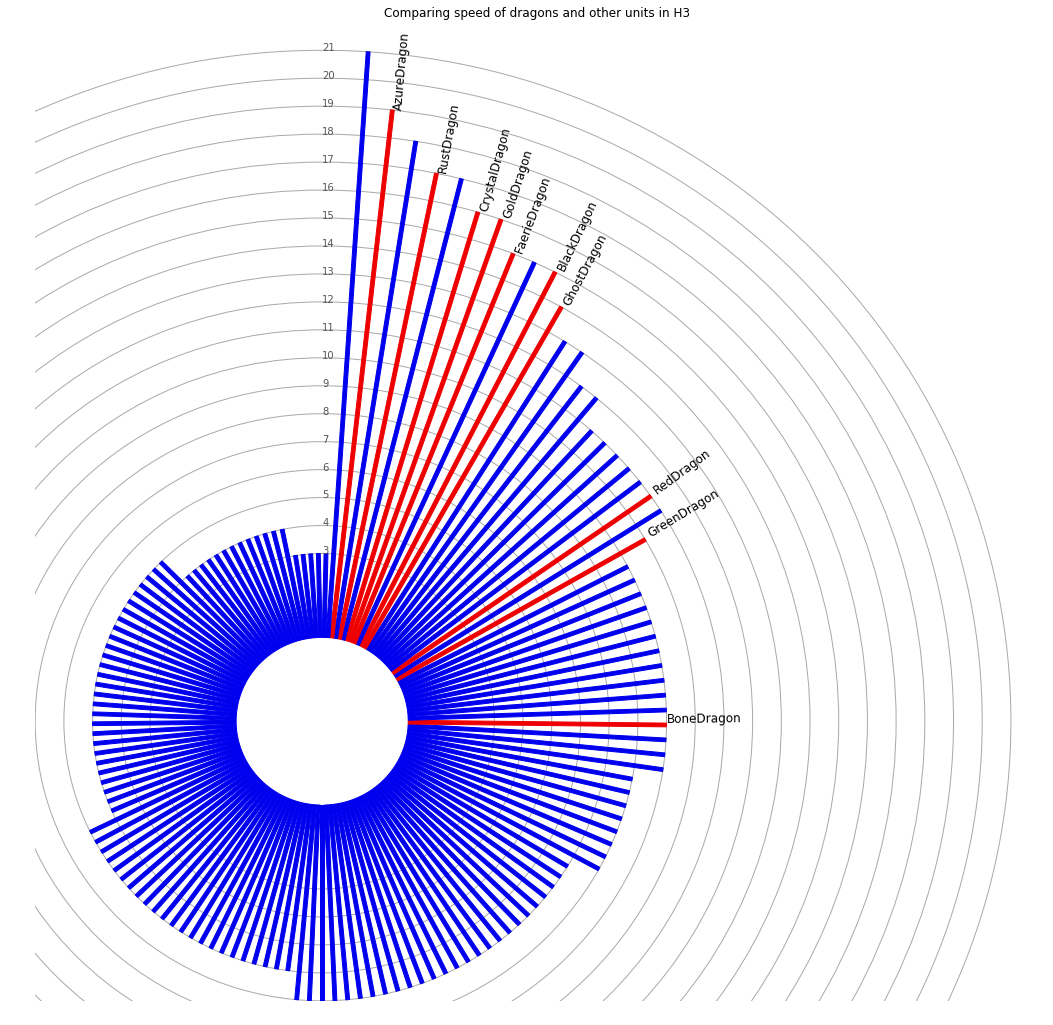

In [15]:
#Ranking #5 - circular barplot - sophisticated, problems analogous to those of splider
#Plot shows ranking of speed of dragons and other units

fig, ax=plt.subplots(1,1)
fig.set_size_inches(18,18)

def dist(x1, x2, y1, y2):
    return (math.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)))

#ax- axis, heights - heights of bars, colors - list/element - by default all colors are the same, same with labels, Rad - radius of inner circle
def circlebar(ax, heights, colors='#EE0000', labels='', Rad=3):
    if (type(colors)==type('star')):
        colors=[colors]*len(heights)
    if (type(labels)==type('star')):
        labels=[labels]*len(heights)
    N=len(heights)
    
    x=[0]*N
    y=[Rad]*N
    deg=2*math.pi/N
    degn=360/N
    
    #Radar written by hand
    for i in range(6, 25, 1):
        f=plt.Circle((0,0), i, fill=None, color='#AAAAAA')
        ax.add_artist(f)
        ax.text(x=0, y=i, s=str(i-Rad), color='#555555')
    
    #Adding bars by rotation matrix: https://en.wikipedia.org/wiki/Rotation_matrix
    #I don't use ax.bar, but geometric figures - it easens rotation
    for i in range(1, N, 1):
        x[i]=math.cos(deg)*x[i-1]-math.sin(deg)*y[i-1]
        y[i]=math.sin(deg)*x[i-1]+math.cos(deg)*y[i-1]
        f=plt.Rectangle(xy=(x[i],y[i]), width=dist(x[i-1],x[i],y[i-1],y[i]), height=heights[i],
                        angle=(2*i-1)*degn/2, color=colors[i])
        ax.add_artist(f)
        #ax.text(x=(x[i])*(2+heights[i])/2, y=(y[i])*(2+heights[i])/2, s=labels[i], fontsize=12, rotation=i*degn+90, verticalalignment='bottom', horizontalalignment='left')
        ax.text(x=(x[i]+x[i-1])*(Rad+heights[i])/(2*Rad), y=(y[i]+y[i-1])*(Rad+heights[i])/(2*Rad), s=labels[i], fontsize=12, rotation=i*degn+90, verticalalignment='bottom', horizontalalignment='left')
        
    f=plt.Rectangle(xy=(x[0],y[0]), width=dist(x[N-1],x[0],y[N-1],y[0]), height=heights[0],
                    angle=(-1)*degn/2, color=colors[0])
    ax.add_artist(f)
    ax.text(x=x[i]*(2+heights[0])/2, y=y[i]*(2+heights[0])/2, s=labels[0], fontsize=12, rotation=0*degn+90)
    
    return


df2=df.copy()
df2.sort_values(by='Speed', inplace=True)

df2.index=range(0,df2.shape[0],1)
k=df2['Unit_name'].str.contains('Dragon$')

df2['Coll']='#0000EE'
df2.loc[k,'Coll']='#EE0000'
df2['Lab']=''
df2.loc[k,'Lab']=df2.loc[k,'Unit_name']

circlebar(ax, heights=df2['Speed'], colors=df2['Coll'], labels=df2['Lab'])

ax.set_title('Comparing speed of dragons and other units in H3')
ax.set_xlim(-10,25)
ax.set_ylim(-10,25)
ax.axis('off')

plt.show()

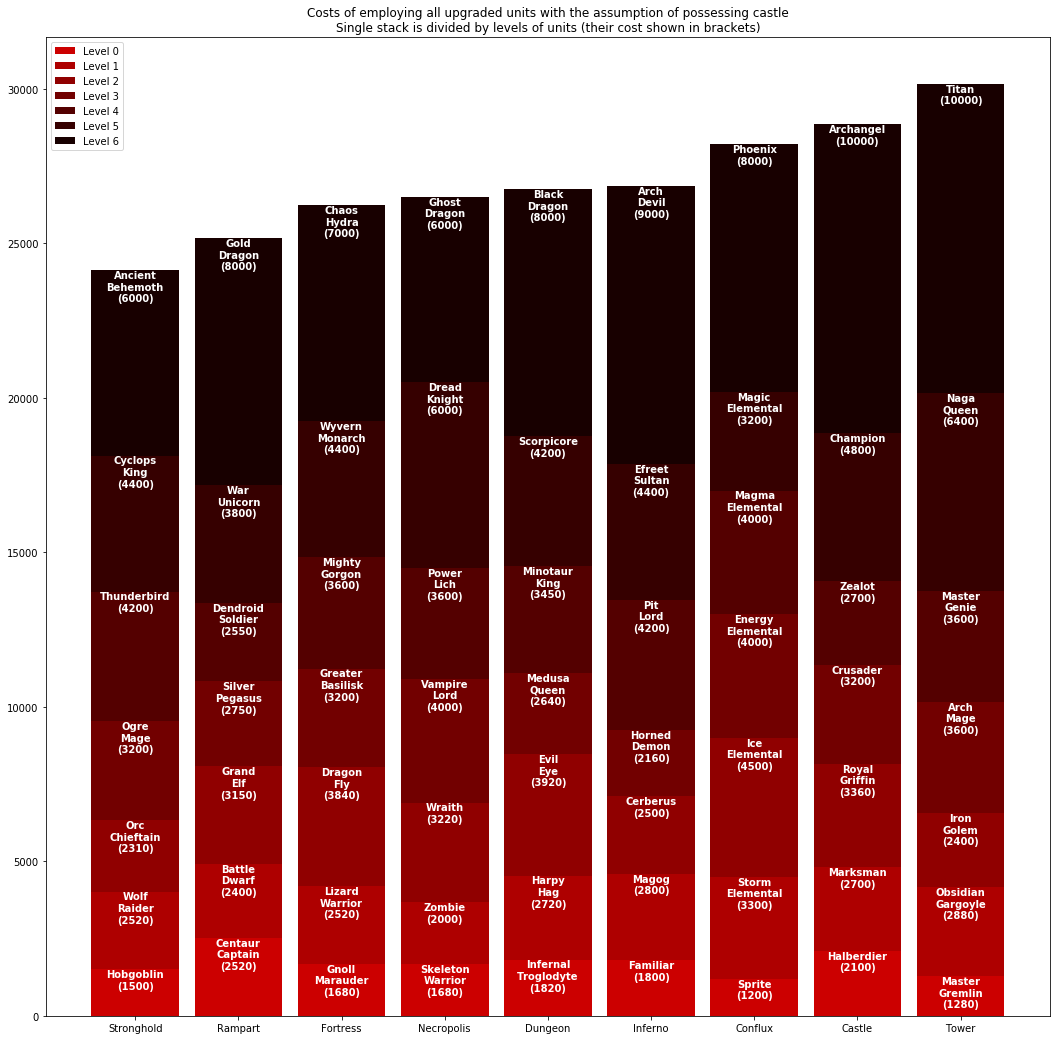

In [16]:
#Part of a whole #1 - stacked barplot

fig, ax=plt.subplots(1,1,figsize=(18,18))

cols=colorize('#CC0000','#000000',7)
legg=[]
for i in range(7):
    legg.append(Patch(facecolor=cols[i], label='Level '+str(i)))

#Modifying dataframe df2, so that I can extract information about sorted castles and units inside them
df2=df.copy()
df2['Cost']=2*df2['Gold']*df2['Growth']
df2=df2[(df2['Level'].str.contains('\+')) & (df2['Castle']!='Neutral')]
df2['Level']=df2['Level'].apply(lambda x: re.sub('\+.*', '', x))

s=df2.columns.get_loc('Cost')
df3=df2.groupby(['Castle'], as_index=False).sum().sort_values(by='Cost')

for i in range(len(df3)):    
    summ=0
    K=df2[df2['Castle']==df3.iat[i,df3.columns.get_loc('Castle')]]
    
    #Adding bars for single town - bottom allows me to stack these barplots
    for j in range(len(K)):
        ax.bar(x=i, bottom=summ, height=K.iat[j,s], width=0.85, color=cols[j])
        #Adding endline in the end of a word, so that I have enough space to put text in bar
        txt=re.sub('([a-z])([A-Z])', '\g<1>\n\g<2>', K.iat[j,K.columns.get_loc('Unit_name')])
        ax.text(x=i, y=summ+K.iat[j,s], s=txt+'\n'+'('+str(K.iat[j,s])+')', verticalalignment='top', horizontalalignment='center', color='#FFFFFF', weight='bold', fontsize=10)
        #Partial sums, that are defining bottom
        summ+=K.iat[j,s]
ax.set_xticks(range(0, len(df3), 1))
ax.set_xticklabels(df3['Castle'])
ax.set_title('Costs of employing all upgraded units with the assumption of possessing castle\nSingle stack is divided by levels of units (their cost shown in brackets)')
ax.legend(handles=legg)
plt.show()

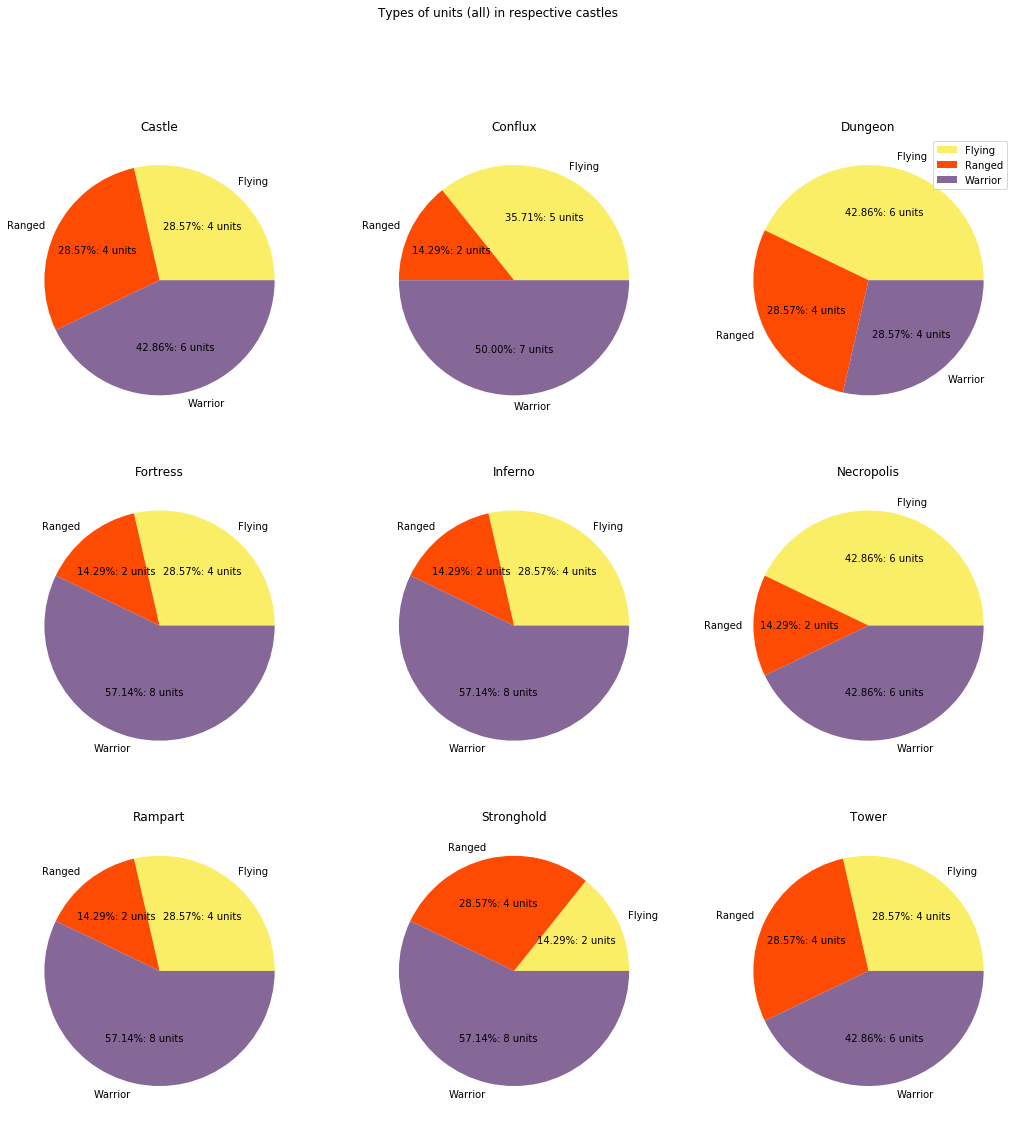

In [17]:
#Part of a whole #2 - pie chart - worst possible plot, circular, enforces comparing areas (a purpose for which human eye don't work well) and ugly
#On this plot I compare types of units in certain castles.

df2=df.copy()
df2['All']=1

df3=df2.groupby(['Castle', 'Type'], as_index=False).count()

fig, ax=plt.subplots(3,3, figsize=(18,18))
castles=np.unique(df2['Castle'])
castles=castles[castles!='Neutral']

#iteration over all axes
for i in range(0, 3, 1):
    for j in range(0, 3, 1):
        adf=df3[df3['Castle']==castles[i*3+j]]
        fa=ax[i][j]
        fa.set_title(castles[i*3+j])
        #Only interesting thing on this plot: string formatting - function, that gets percents, spits formatted output
        fa.pie(x=adf['All'], labels=adf['Type'], colors=['#FAEE66', '#FE4B03', '#856798'], autopct=lambda perc: ('%.2f%s: %d units' %(perc, '%', round(perc*sum(adf['All'])/100,0))))
        fa.axis('off')
    
ax[0][2].legend()
fig.suptitle('Types of units (all) in respective castles')
plt.show()

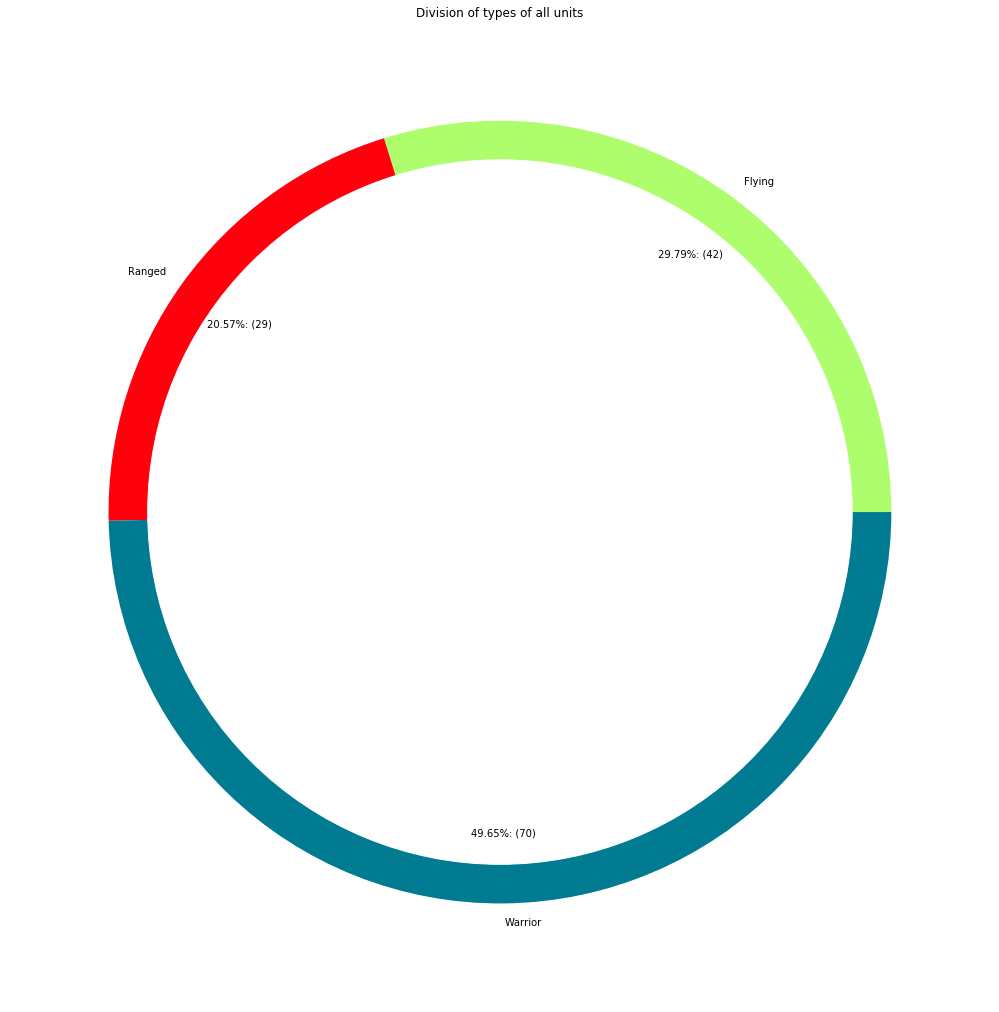

In [18]:
#Part of a whole #3 - donut plot - better than pie chart, for compares length
#Analogous plot as before, now without comparing casltes
df2=df.copy()
df2['All']=1
df3=df2.groupby(['Type'], as_index=False).count()

fig, ax=plt.subplots(1,1,figsize=(18,18))
ax.pie(x=df3['All'], labels=df3['Type'], labeldistance=1.05, colors=['#AEFD6C', '#FF000D', '#017B92'], autopct=lambda perc: ('%.2f%s: (%d)' %(perc, '%', round(perc*sum(df3['All'])/100,0))), pctdistance=0.82)
f=plt.Circle((0,0), 0.9, color='#FFFFFF')
ax.add_artist(f)
ax.set_title('Division of types of all units')

plt.show()

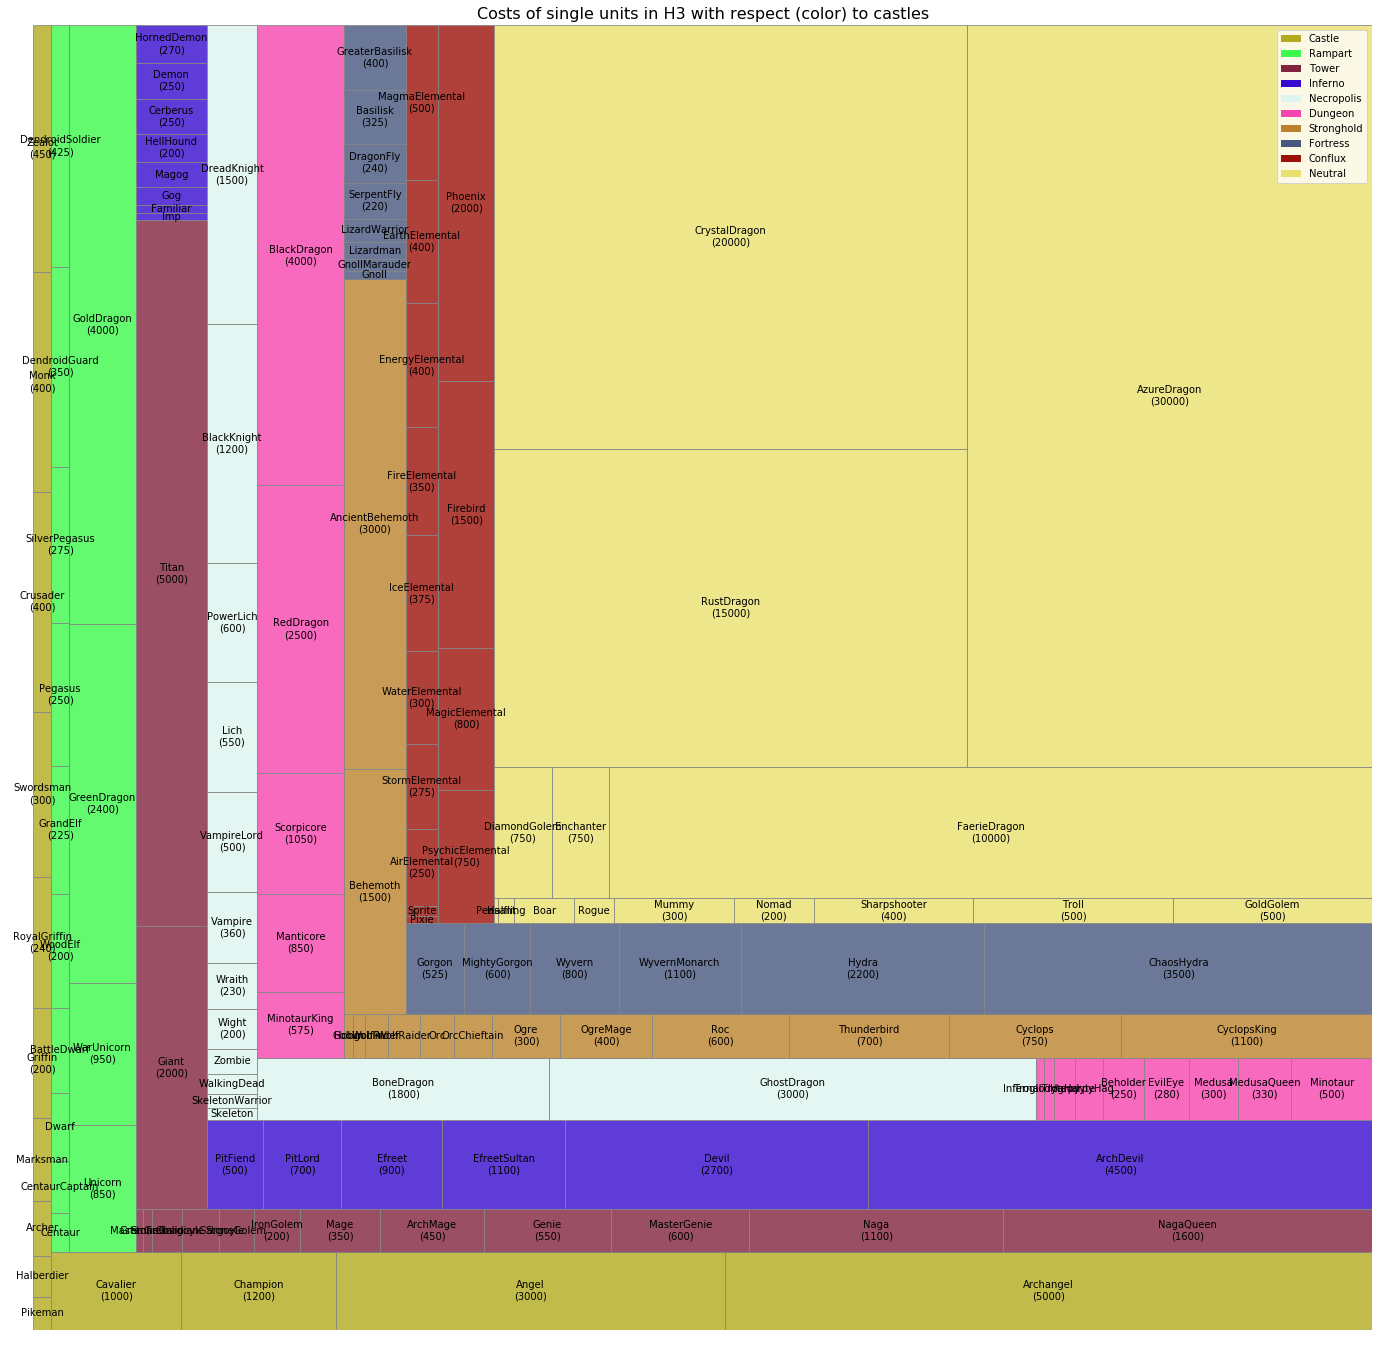

In [19]:
#Part of a whole #5 - Treeplot - allows me to analyze hierarchized sets (like dendrogram or sunburst)
#Plot is imperfect - observation should go like a snake, so that castles would be shown purely hierarchically, though most crucial observations are visible still
#I could have prettier plot, but I wanted to show customization of this plot

df2=df.copy()
df2['All']=1
df2['Kappa']=df2.index

df2=df2.groupby(['Castle'], as_index=False).sum().sort_values(by='Kappa')
#print(df2)


fig, ax=plt.subplots(1,1)
fig.set_size_inches(24,24)

clr=[]
lg=[]
Z=df2.columns.get_loc('All')
W=df2.columns.get_loc('Castle')
for i in range(0, df2.shape[0], 1):
    s1, s2=gen_rand_colors(90)
    #clr.extend(colorize(s1, s2, df2.iat[i,Z])) #Interplotating by colors - rather not useful, effect is washy
    clr.extend(colorize(s1, s1, df2.iat[i,Z]))
    lg.append(Patch(facecolor=s1, label=df2.iat[i,W]))
#print(len(clr))

lb=df['Unit_name']+'\n('+df['Gold'].astype(str)+')'
for i in range(0, len(lb), 1):
    if (df.at[i,'Gold']<200):
        lb[i]=df.at[i,'Unit_name']
        
squarify.plot(sizes=df['Gold'], label=lb, alpha=0.8, ax=ax, color=clr, text_kwargs={'fontsize': 10}, bar_kwargs={'fill': True, 'edgecolor': '#888888'})
ax.set_title('Costs of single units in H3 with respect (color) to castles', fontsize=16)
ax.axis('off')
ax.legend(handles=lg)

plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()


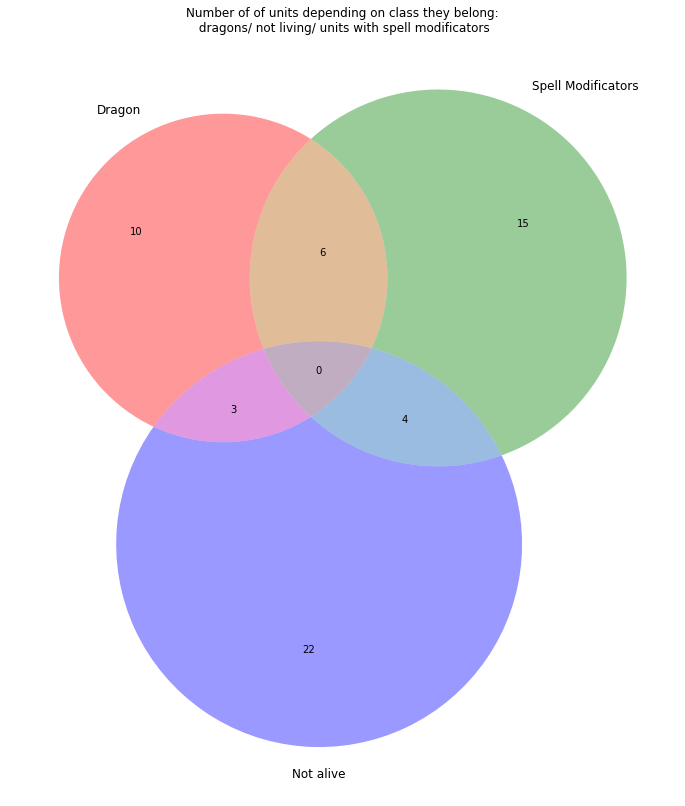

In [20]:
#Part of a whole #6 - Venn diagram - useful for showing logicznego iloczynu między kilkoma zbiorami
#Plot shows count of three parameters of units and their cunjunctions
#The only plot able to show relations between sets

df2=df.copy()
a=[0]*3
gr=3

a[0]=df2['Unit_name'].str.contains('Dragon$')
a[1]=df2['Special_abilities'].str.contains('[sS]pell')
a[2]=df2['Special_abilities'].str.contains('Un(living|dead)', regex=True)

z=pow(2,gr)
aef=[0]*z
#Exponential generator of logic multiplies - I iterate over numbers from 0 to 2^k-1, where k is number of sets - every number represents conjunction
#ex. 6 means 110 - I take logical multiplication of 1,2 set, 0 remains unused. Or 5 - 101 - 0. and 2nd set merged, 1st unused
#That is how venn diagram works - I just delete 1st element (omega space, P(omega)=1 - whole reality)
for i in range(z):
    f=[True]*df2.shape[0]
    j=i
    ij=0
    
    while (j>0):
        if (j%2==1):
            f=f&a[ij]
        ij+=1
        j=j//2
        
    aef[i]=sum(f)
fig, ax=plt.subplots(1,1, figsize=(14,14))
venn3(aef[1:z], set_labels=['Dragon','Spell Modificators', 'Not alive'], ax=ax)
ax.set_title('Number of of units depending on class they belong:\n dragons/ not living/ units with spell modificators')
plt.show()

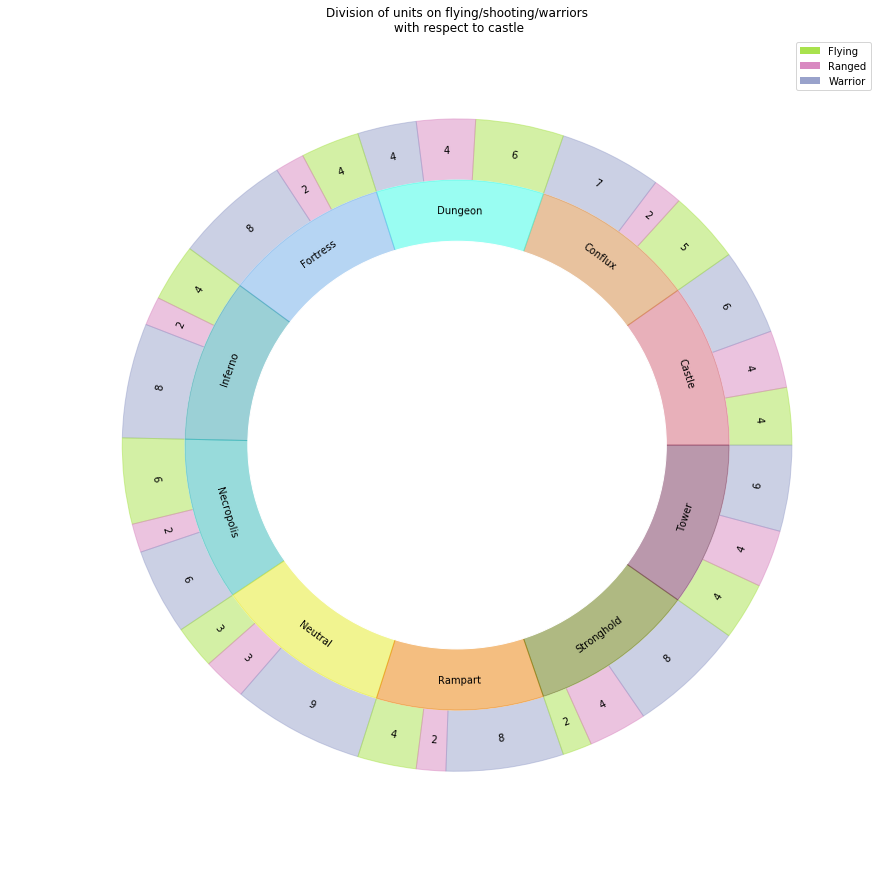

In [21]:
#Part of a whole #7 - sunburst - allow doing things impossible with simple pie/donut - hierarchization
#Dendrogram is usually considered better - cartesian, not polar, but I consider it less informative
#Plot shows division of units with respect to castles

#ax - axis, df - dataframe, cols - columns from most inner to most outer, leg - legend
def sunnburst(ax, df, cols, leg=[]):
    df['All']=1
    t1=0
    Cl=len(cols)
    summ=df.shape[0]
    
    #Creating new dataframe with color for wedges
    colz=['Column', 'Value', 'Color', 'Used']    
    allez=[] 
    for j in range(Cl):
        tp=np.unique(df[cols[j]])
        for i in range(0, len(tp),1):
            c1, c1=gen_rand_colors(0)
            allez.append([cols[j], tp[i], c1, 0])
    dfendet=pd.DataFrame.from_records(allez, columns=colz)
    
    #Loop over all elements, that I hierarchize
    for j in range(0, Cl, 1):
        #Grouping, finding indexes: W - last column(for label), Z-count
        df3=df.groupby(cols[0:Cl-j], as_index=False).sum()
        Z=df3.columns.get_loc('All')
        W=df3.columns.get_loc(cols[Cl-j-1])
        t1=0
        #Iterating over all observations in dataframe
        for i in range(0, df3.shape[0], 1):
            secsum=df3.iat[i,Z]
            view=dfendet[(dfendet['Column']==cols[Cl-j-1])&(dfendet['Value']==df3.iat[i,W])]
            colval=view.iat[0,2]
            
            #Adding wedge changing angle t1 - new beginning of hemicycle in degrees, dg and rad used to display text
            f=patch.Wedge(center=(0,0), r=1+(Cl-j)*0.3, theta1=t1, theta2=t1+(secsum/summ)*360, color=colval, alpha=0.5)
            dg=(2*t1+(secsum/summ)*360)/2
            rad=1+(Cl-j)*0.3-0.15
            t1=t1+(secsum/summ)*360
            ax.add_artist(f)
            
            #Angle to show text
            sdg=90+dg
            if (sdg>90 and sdg<270):
                sdg-=180
            
            #Most inner circle - show text. What's important, sin and cos work in radians - therefore conversion
            if (j==Cl-1):
                ax.text(x=rad*math.cos(dg*math.pi/180), y=rad*math.sin(dg*math.pi/180), s=df3.iat[i,W], rotation=sdg, verticalalignment='center', horizontalalignment='center')
            #Outer circles - add to legend, add text - number of certain observations
            else:
                if (view.iat[0,3]==0):
                    leg.append(Patch(facecolor=colval, label=view.iat[0,1]))
                    dfendet.loc[(dfendet['Column']==cols[Cl-j-1])&(dfendet['Value']==df3.iat[i,W]),'Used']=1
                ax.text(x=rad*math.cos(dg*math.pi/180), y=rad*math.sin(dg*math.pi/180), s=df3.iat[i,Z], rotation=sdg, verticalalignment='center', horizontalalignment='center') 
                
            
            
        f=patch.Wedge(center=(0,0), r=1+(Cl-j-1)*0.3, theta1=0, theta2=360, color='white', alpha=1)
        ax.add_artist(f)
    ax.axis('off')
    return

df2=df.copy()
fig, ax=plt.subplots(1,1,figsize=(15,15))
lg=[]
sunnburst(ax=ax, df=df2, cols=['Castle', 'Type'], leg=lg)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title('Division of units on flying/shooting/warriors\n with respect to castle')
ax.legend(handles=lg)
plt.show()